In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
import add_funcs_8727 as afc
import scipy.integrate as integrate
from tqdm import tqdm

In [15]:
#Set constants of interest
wl_min, wl_max = 8200, 9100 # The wavelength limits of the grid we are interested in. Default: 8200, 9100

pre_computed_path = os.getcwd() + '/profile_library/' # The path to the CaNARY simulated spectra library
line_profile_fnames = os.listdir(pre_computed_path) # The names of all line profiles in the CaNARY library

set_to_fit = 'observations' # 'observations' or 'models'
save_fname = 'NOTE_post_130325_CI8727_signal_observations_autopilotoff.txt' # File to store our fitting results

autopilot = True # If True, the program will perform all fits without any constraints. Use only if you want to get a quick look at a big sample
chi2_threshold = 2 # The normalised threshold considered as the 1 sigma uncertainty range for P_CI (best fit is always chi2 = 1)

In [19]:
# Read in the spectra. As long as your outputs are fname_list, spectra_list and epoch_list, you can adjust these however you like
epoch_list = [295]
fname_list = ['example_spectrum.csv']
spectra_list = [np.loadtxt(fname_list[0], delimiter = ',')]

In [20]:
def write_output(fname, epoch, total_corrected_CaNIR_lum, P_CI, P_CI_lower, P_CI_upper, score_per_datapoint):
    
    #=============================================================================================
    #Add the output_line

    output_string = (fname + ',' + str(epoch) + ',' + '{0:.3g}'.format(total_corrected_CaNIR_lum) + ',' +
                     '{0:.3f}'.format(P_CI) + ',' + '{0:.3f}'.format(P_CI_lower) + ',' +
                     '{0:.3f}'.format(P_CI_upper) + ',' + '{0:.3f}'.format(score_per_datapoint) + '\n')

    with open('results/' + save_fname, "a") as file:
        file.write(output_string)

Before starting, check if you are not overwriting an existing fits file.
                     If all looks good, answer [y]y
Current index is:  0
Below we plot spectrum:  example_spectrum.csv


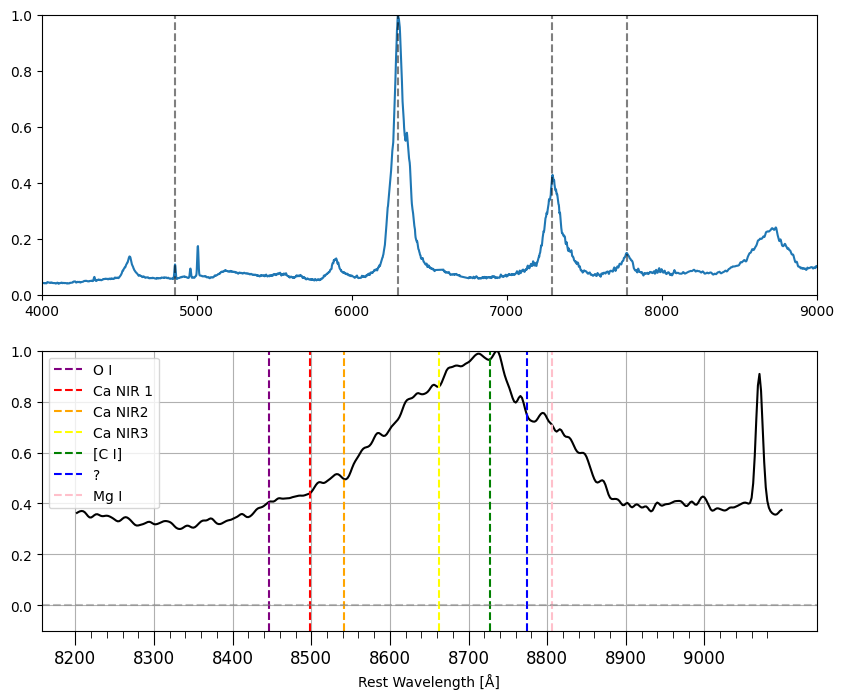

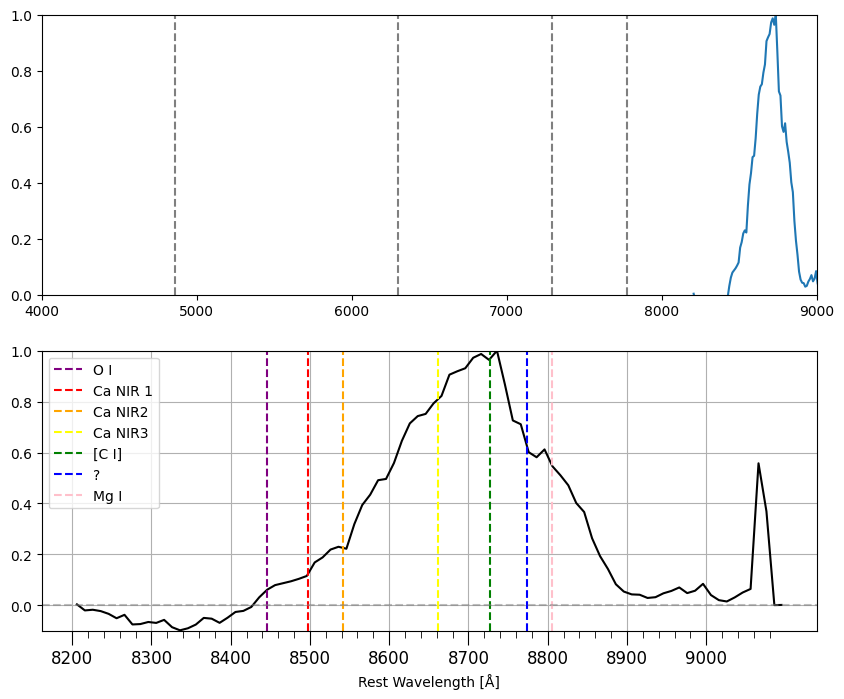

The best score is:  0.38748742269045483
Below we plot the best fit for  example_spectrum.csv
We fitted  3069  out of  3069  profiles.
The best score per datapoint was:  0.00
This profile had the following parameters:  pCaII_t05p00_pCI_f09p00_pOI_t00p00_pMgI_f00p00_vout_5500_tauMgI_0p00_parabola.csv


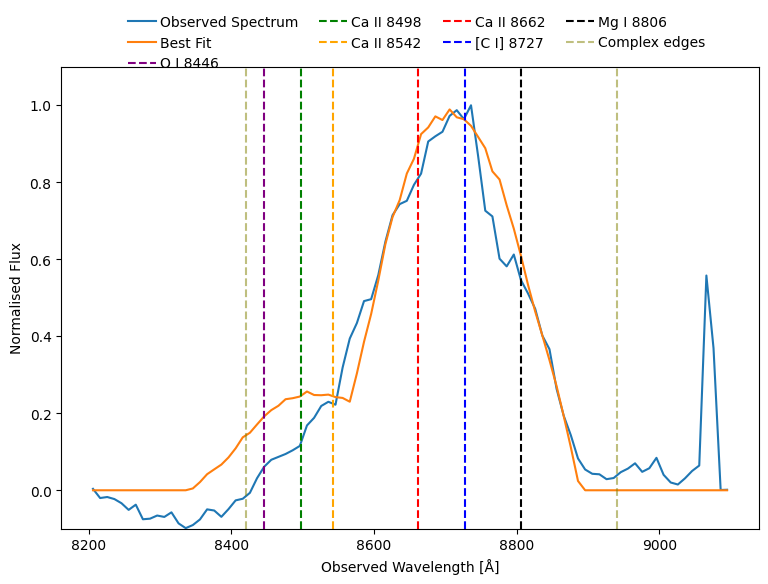

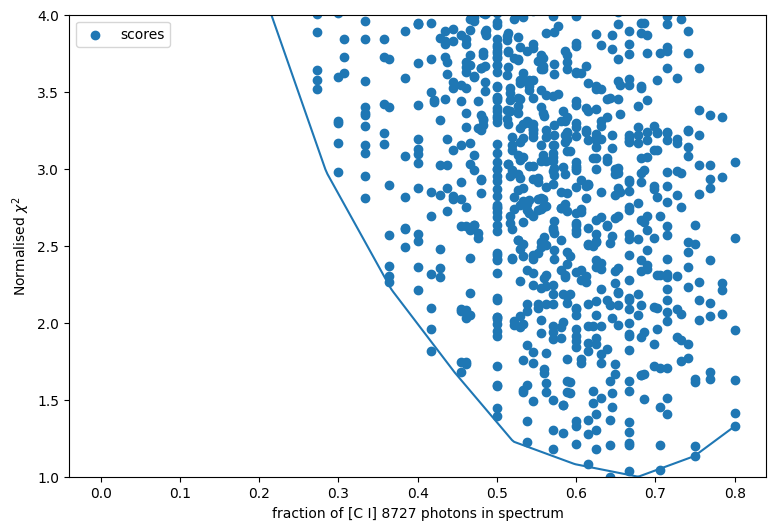

In the plot above, the best fit P_CI is:  0.64
The uncertainty range is:  0.40  to  1.00


In [21]:
# The Main program: find the best L_8727 fit for all provided SNe spectra.

start_index = 0 #The index in 'spectra_list' from where to start, in case we have to interrupt the fitting prematurely
current_index = 0 # 

safety_check = input("""Before starting, check if you are not overwriting an existing fits file.
                     If all looks good, answer [y]""")
if safety_check != 'y':
    sys.exit()
    

# For each SN spectrum ...
for i in range(len(spectra_list)):
    
    #==========================================================================================================
    # In this section we read in the spectra

    print('Current index is: ', current_index) 
    if current_index < start_index: # Little trick to start where we stopped last time
        current_index += 1
        continue
    
    # Open the spectrum
    this_spectrum = spectra_list[i]
    this_epoch = epoch_list[i]
    this_fname = fname_list[i]
    
    # Assign wl+flux and remove NANS
    wl, flux = this_spectrum[:, 0], this_spectrum[:, 1]
    wl, flux = wl[flux > -np.inf], flux[flux > -np.inf] #This step removes any NANs in the spectra
    
    print('Below we plot spectrum: ', this_fname)
    
    afc.plot_individual_spectrum(wl, flux, wl_min, wl_max)
    #==========================================================================================================
    
    #==========================================================================================================
    # Now we perform some data processing steps and plot again
    
    wl_zoom, flux_zoom = wl[(wl_min < wl) * (wl_max > wl)], flux[(wl_min < wl) * (wl_max > wl)] # Zoom in
    
    processed_wl, flux_binned = afc.rebin_spectrum(wl_zoom, flux_zoom) # This rebins each spectrum to bins of rouhgly 10 Å for best S/N
    
    processed_flux, adjusted_total_flux = afc.remove_continuum_flux(processed_wl, flux_binned) # Remove a flat continuum
     
    afc.plot_individual_spectrum(processed_wl, processed_flux, wl_min, wl_max) # Plot the spectrum after the processing steps
    #==========================================================================================================
    
    #==========================================================================================================
    # Lets obtain the constraints used to select the subsample of the line profile library to compare to
    
    if autopilot == False:
        constraints_list = afc.constrain_parameter_space(wl, flux, this_epoch) # Obtain the constraints from the user. Use the old wl, flux to be able to plot the entire spectrum
    
    elif autopilot == True:
        constraints_list = ['y', 'y', [3000,7001], [8420,8940]]  # Put no constraints, fit to all simulated line profiles
    #==========================================================================================================
    
    #==========================================================================================================
    # Start comparing to the subset of line profiles from the library
    score_list, n_valid = [], 0

    for j in range(len(line_profile_fnames)): # Start the fitting process

        valid = afc.check_constraints(constraints_list, line_profile_fnames[j]) # Check if this profile is within the constraints

        if valid:
            n_valid += 1

            simulated_data = np.loadtxt(pre_computed_path + line_profile_fnames[j], delimiter = ',') # Load in the simulated profile
            simulated_wl, simulated_flux = simulated_data[:, 0], simulated_data[:, 1] 
            
            line_complex_bounds = constraints_list[3] # The wl region considered when determining the chi2 score
            this_score = afc.calculate_score(processed_wl, processed_flux, simulated_wl, simulated_flux, line_complex_bounds) # Determine fit quality
            
            score_list.append(this_score)
            
        else:
            this_score = np.inf
            score_list.append(this_score) # Append a score anyways to assure correct indexing in future
   
    # Get the best scoring profile and plot it
    print('The best score is: ', min(score_list))
    print('Below we plot the best fit for ', this_fname)
    print('We fitted ', n_valid, ' out of ', len(line_profile_fnames), ' profiles.')

    score_per_datapoint = np.min(score_list)/len(processed_wl)
    print('The best score per datapoint was: ', '{0:.2f}'.format(score_per_datapoint))
    
    afc.plot_best_fit(score_list, processed_wl, processed_flux, line_complex_bounds, pre_computed_path, line_profile_fnames)
    
    # Get the lower and upper 1 sigma bounds and plot the chi2 scores vs P_CI
    best_P_CI, left_P_CI_bound, right_P_CI_bound = afc.plot_chi2_scores(score_list, line_profile_fnames, chi2_threshold, mode = 'CI')
    #==========================================================================================================
    
    #==========================================================================================================
    # Finally store the output
    write_output(this_fname, this_epoch, adjusted_total_flux, best_P_CI, left_P_CI_bound, right_P_CI_bound, score_per_datapoint)
    
    #==========================================================================================================
    
    current_index += 1 # Don't forget to increase the current_index